# 2023 추천 여행지

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

C:\Users\cutad\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../data_travel/2023 추천 여행지.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20240423,문경하면 문경새재 이보다 좋은 곳이 있을까 싶다. 그런데 오미자터널은 찾는 분들의 ...,"텐데 <b>추천<\/b>을 하기가 이제 겁난다."" 하여간 오늘 갈 곳은 봉명산출렁다...",2023년 12월에 완공된 문경 추천여행지 봉명산출렁다리
1,20230112,"안 가본 사람은 있어도 한번 간 사람은 없다고 내멋대로 정의하는 산천어 축제, 아직...",#화천산천어축제 #<b>2023년<\/b>산천어축제 #<b>2023년<\/b>화천산...,"2023년 화천 산천어 축제, 얼음낚시 겨울여행지 추천(+예매.낚시노하우.숙박)"
2,20230127,"안녕하세요. 노랑풍선입니다💛 남들 다 가는 그런 여행 말고, 특별하게 내 마음을 끌...",<b>2023년<\/b> 관광트렌드 해외<b>여행지<\/b> <b>추천<\/b> B...,2023년 관광트렌드 해외여행지 추천 BEST4
3,20231213,"점점 쌀쌀해지기 시작하며 따뜻한 날씨의 휴양지가 떠오르는 12월, 카리브해의 숨겨진...",장거리 <b>여행지<\/b>다. 먼 거리인 만큼 칸쿤 여행을 떠난다면 최소 5박 이...,"[2023년 12월 여행지 추천] 카리브해 지상낙원, 멕시코 대표 신혼여행지 '칸쿤..."
4,20230312,요즘 날이 따뜻하면서 그동안 숨어있던 자연이 하나둘씩 기지개를 켜고 있어요 저도 남...,본 <b>2023년<\/b> 매화 개화시기 국내 봄 <b>여행지<\/b> 경주 꽃놀...,2023년 매화 개화시기 국내 봄 여행지 경주 꽃놀이


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['여행지', '2023년', '여행', '추천', '사진', '코스', '사람', '마을','방문', '다양', '정도', '모습',
                        '생각', '거리', '이용', '위치', '유명', '가능', '소개', '선정', '시작', '오늘', '관광', '지역', '장소',
                        '세계', '올해', '기간', '제목', '때문', '주차장', '예약', '투어', '공간', '구경', '문화', '날씨', '인기',
                        '나라', '주변', '운영', '마음', '무료', '자리', '최고', '준비', '대표', '매력', '주차', '감상', '아래',
                        '분위기', '정보', '입구', '이동', '사랑', '할인', '특별', '일정', '시설', '건물', '진행', '계획', '보이',
                        '가지', '시기', '대하', '입장료', '이름', '아침', '도착', '경우', '규모', '입장', '포스팅', '마지막', '가격',
                        '촬영', '접기펴기', '이야기', '사용', '포토', '작품', '이유', '기억', '출처', '상품', '시대', '하루', '조성',
                        '인생', '필요', '친구', '워크', '사이', '경험', '출발', '선택', '영상', '처음', '최대', '이후', '제공', '기분',
                        '중간', '지금', '계단', '요즘', '개인', '프로그램', '관광객', '곳곳', '소리', '요금', '오후', '주소', '안내',
                        '필수', '행사', '근처', '안전', '방법', '안녕하세요', '부분', '포함', '시즌', '정상', '이벤트', '지정', '작년',
                        '의미', '여행자', '공연', '배경', '전체', '자랑', '당시', '식사', '기준', '지도', '내부', '저녁', '구간',
                        '오픈', '정리', '패키지', '예술', '얼음', '일반', '네이버', '재미', '센터', '국가', '여행객', '후기', '그림',
                        '세상', '탑승',  '홈페이지', '서비스', '마련', '포인트', '참고', '먹거리', '일상', '소요', '자체', '비교',
                        '예정', '검색'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 2min 52s
Wall time: 6min 12s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240423,문경하면 문경새재 이보다 좋은 곳이 있을까 싶다 그런데 오미자터널은 찾는 분들의 평...,텐데 b추천b을 하기가 이제 겁난다 하여간 오늘 갈 곳은 봉명산출렁다리라는 곳이다 ...,2023년 12월에 완공된 문경 추천여행지 봉명산출렁다리,문경 면 문경새재 곳 오미자 터널 분 평 대조 적 라 분 분 번 보 만 터 데 기 ...,터 데 기 곳 봉명산 다리 곳 지나 봉명산 다리 문경 만 문경 만 문경 문경 경북 보 곳,완공 되 문경 봉명산 다리
1,20230112,안 가본 사람은 있어도 한번 간 사람은 없다고 내멋대로 정의하는 산천어 축제 아직 ...,화천산천어축제 b2023년b산천어축제 b2023년b화천산천어축제 겨울행사 겨울축제 ...,2023년 화천 산천어 축제 얼음낚시 겨울여행지 추천예매낚시노하우숙박,번 정의 산천어 축제 커플 가족 남녀 노소 인터파크 티켓 예매 고고 눈 화천 뻔 숙...,화천 산천어 축제 산천어 축제 화천 산천어 축제 겨울 겨울 축제 겨울 축제 가족 가...,화천 산천어 축제 얼음낚시 겨울 예매 낚시 노하우 숙박
2,20230127,안녕하세요 노랑풍선입니다 남들 다 가는 그런 여행 말고 특별하게 내 마음을 끌어당길...,b2023년b 관광트렌드 해외b여행지b b추천b BEST4 유니크하게 즐겨보자 일본...,2023년 관광트렌드 해외여행지 추천 BEST4,노랑 풍선 남 말 것 만 걱정 노랑 풍선 노랑 풍선 제안 트렌드 해외 대만 스페인 ...,트렌드 해외 유니크 것 보 일본 오사카 트렌드 번 해외 은 일본 오사카 일본 오사카...,트렌드 해외
3,20231213,점점 쌀쌀해지기 시작하며 따뜻한 날씨의 휴양지가 떠오르는 12월 카리브해의 숨겨진 ...,장거리 b여행지b다 먼 거리인 만큼 칸쿤 여행을 떠난다면 최소 5박 이상은 머무는 ...,2023년 12월 여행지 추천 카리브해 지상낙원 멕시코 대표 신혼여행지 칸쿤의 모든 것,기 휴양지 카리브해 보석 휴양지 칸쿤 도시 지상 낙원 불리 걱정 신혼부부 허니문 곳...,장거리 칸쿤 최소 박 박 박 야 관광지 액티비티,카리브 해 지상 낙원 멕시코 신혼여행 지 칸쿤
4,20230312,요즘 날이 따뜻하면서 그동안 숨어있던 자연이 하나둘씩 기지개를 켜고 있어요 저도 남...,본 b2023년b 매화 개화시기 국내 봄 b여행지b 경주 꽃놀이를 어디서 하면 좋을...,2023년 매화 개화시기 국내 봄 여행지 경주 꽃놀이,면 그동안 숨 자연 기지개 남편 랑 눈 알 보 매화 개화 국내 봄 경주 꽃놀이 서 ...,보 매화 개화 국내 봄 경주 꽃놀이 서 시 기 경주 매화 피 만개,매화 개화 국내 봄 경주 꽃놀이


In [11]:
# 전처리한 결과 csv로 저장 
df.to_csv('23여행지_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [7]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [8]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [9]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
18471,축제,2665
717,겨울,1719
1759,국내,1680
1281,공원,1498
136,가을,1356
20870,풍경,1310
18246,체험,1154
7113,바다,1117
6263,명소,1101
15614,일본,1035


In [10]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['축제',
 '겨울',
 '국내',
 '공원',
 '가을',
 '풍경',
 '체험',
 '바다',
 '명소',
 '일본',
 '벚꽃',
 '호텔',
 '제주',
 '해외',
 '도시',
 '카페',
 '여름',
 '서울',
 '자연',
 '부산',
 '가족',
 '단풍',
 '강원도',
 '한국',
 '정원',
 '리조트',
 '관광지',
 '여수',
 '전망대',
 '경기도']

### [preprocessed_description]

In [12]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [13]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
320,국내,268
2940,축제,243
137,겨울,180
18,가을,158
3433,해외,144
2051,여행사,107
2036,여름,79
2438,일본,77
1011,명소,74
1228,벚꽃,72


### [preprocessed_title]

In [14]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [15]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
156,국내,203
1492,축제,124
63,겨울,122
11,가을,105
1749,해외,101
523,명소,57
31,강원도,42
1273,일본,41
1357,제주,40
15,가족,40


## 3. 계절별로 데이터프레임 생성

In [16]:
# 특정 키워드 포함 행 필터링 함수
def filter_inclusive(df, keyword):
    return df[df['preprocessed_body'].str.contains(keyword, na=False)]

# 특정 키워드 포함하지 않는 행 제거 함수
def filter_exclusive(df, exclude_keywords):
    return df[~df['preprocessed_body'].str.contains('|'.join(exclude_keywords), na=False)]

# 봄 데이터프레임 생성
spring_df = filter_inclusive(df, '봄')
spring_df = filter_exclusive(spring_df, ['여름', '가을', '겨울'])

# 여름 데이터프레임 생성
summer_df = filter_inclusive(df, '여름')
summer_df = filter_exclusive(summer_df, ['봄', '가을', '겨울'])

# 가을 데이터프레임 생성
autumn_df = filter_inclusive(df, '가을')
autumn_df = filter_exclusive(autumn_df, ['봄', '여름', '겨울'])

# 겨울 데이터프레임 생성
winter_df = filter_inclusive(df, '겨울')
winter_df = filter_exclusive(winter_df, ['봄', '여름', '가을'])

# preprocessed_body, postdate 열만 추출
spring_body = spring_df[['preprocessed_body', 'postdate']]
summer_body = summer_df[['preprocessed_body', 'postdate']]
autumn_body = autumn_df[['preprocessed_body', 'postdate']]
winter_body = winter_df[['preprocessed_body', 'postdate']]

In [17]:
# # 사계절 데이터프레임 csv로 저장
# spring_body.to_csv('23여행지_전처리_봄.csv', index=False, encoding='utf-8-sig')
# summer_body.to_csv('23여행지_전처리_여름.csv', index=False, encoding='utf-8-sig')
# autumn_body.to_csv('23여행지_전처리_가을.csv', index=False, encoding='utf-8-sig')
# winter_body.to_csv('23여행지_전처리_겨울.csv', index=False, encoding='utf-8-sig')

### [spring]

In [18]:
# 봄 데이터프레임에 대해 단어 빈도 계산
spring_word_counts = explode_and_count(spring_body, 'preprocessed_body')

# 한 글자 단어 제외
spring_word_counts = spring_word_counts[spring_word_counts['word'].str.len() > 1]
spring_word_counts.head(30)

,word,count
1,벚꽃,678
3,축제,523
7,공원,318
11,매화,233
12,명소,227
15,봄꽃,200
20,개화,182
21,국내,163
23,산수유,145
24,풍경,144


### [summer]

In [19]:
# 여름 데이터프레임에 대해 단어 빈도 계산
summer_word_counts = explode_and_count(summer_body, 'preprocessed_body')

# 한 글자 단어 제외
summer_word_counts = summer_word_counts[summer_word_counts['word'].str.len() > 1]
summer_word_counts.head(30)

,word,count
3,여름,323
6,축제,253
9,바다,223
10,국내,222
19,계곡,163
21,공원,138
22,체험,132
23,일본,131
24,부산,126
27,해변,117


### [autumn]

In [20]:
# 가을 데이터프레임에 대해 단어 빈도 계산
autumn_word_counts = explode_and_count(autumn_body, 'preprocessed_body')

# 한 글자 단어 제외
autumn_word_counts = autumn_word_counts[autumn_word_counts['word'].str.len() > 1]
autumn_word_counts.head(30)

,word,count
1,가을,638
4,축제,311
7,단풍,269
13,공원,183
16,풍경,163
18,체험,142
19,정원,141
20,국내,138
22,명소,137
24,퀘벡,127


### [winter]

In [21]:
# 겨울 데이터프레임에 대해 단어 빈도 계산
winter_word_counts = explode_and_count(winter_body, 'preprocessed_body')

# 한 글자 단어 제외
winter_word_counts = winter_word_counts[winter_word_counts['word'].str.len() > 1]
winter_word_counts.head(30)

,word,count
1,겨울,976
4,축제,497
9,썰매,324
13,국내,285
21,체험,191
22,풍경,190
24,가족,173
25,커피,166
26,일본,165
28,강원도,156


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'축제': 2665,
 '겨울': 1719,
 '국내': 1680,
 '공원': 1498,
 '가을': 1356,
 '풍경': 1310,
 '체험': 1154,
 '바다': 1117,
 '명소': 1101,
 '일본': 1035,
 '벚꽃': 1014,
 '호텔': 890,
 '제주': 811,
 '해외': 795,
 '도시': 785,
 '카페': 783,
 '여름': 767,
 '서울': 762,
 '자연': 721,
 '부산': 716,
 '가족': 714,
 '단풍': 666,
 '강원도': 654,
 '한국': 637,
 '정원': 636,
 '리조트': 610,
 '관광지': 583,
 '여수': 545,
 '전망대': 540,
 '경기도': 535,
 '다리': 518,
 '해변': 513,
 '제주도': 494,
 '도쿄': 493,
 '숙소': 492,
 '역사': 490,
 '힐링': 480,
 '전시': 476,
 '느낌': 475,
 '음식': 459,
 '맛집': 459,
 '전남': 453,
 '베트남': 436,
 '산책': 435,
 '나무': 430,
 '경남': 429,
 '가이드': 427,
 '박물관': 417,
 '재생': 417,
 '볼거리': 413,
 '계곡': 409,
 '하늘': 391,
 '유럽': 386,
 '강릉': 386,
 '추억': 385,
 '커피': 384,
 '강원': 383,
 '썰매': 375,
 '자유': 373,
 '관람': 371,
 '매화': 371,
 '확인': 366,
 '주말': 355,
 '버스': 351,
 '근교': 351,
 '크리스마스': 348,
 '태국': 347,
 '해수욕장': 343,
 '시장': 336,
 '여행사': 335,
 '신혼여행': 334,
 '대구': 323,
 '혜택': 323,
 '숙박': 322,
 '개화': 321,
 '발리': 314,
 '행복': 311,
 '온천': 311,
 '항공': 310,
 '데이트': 306,
 '쇼핑': 301

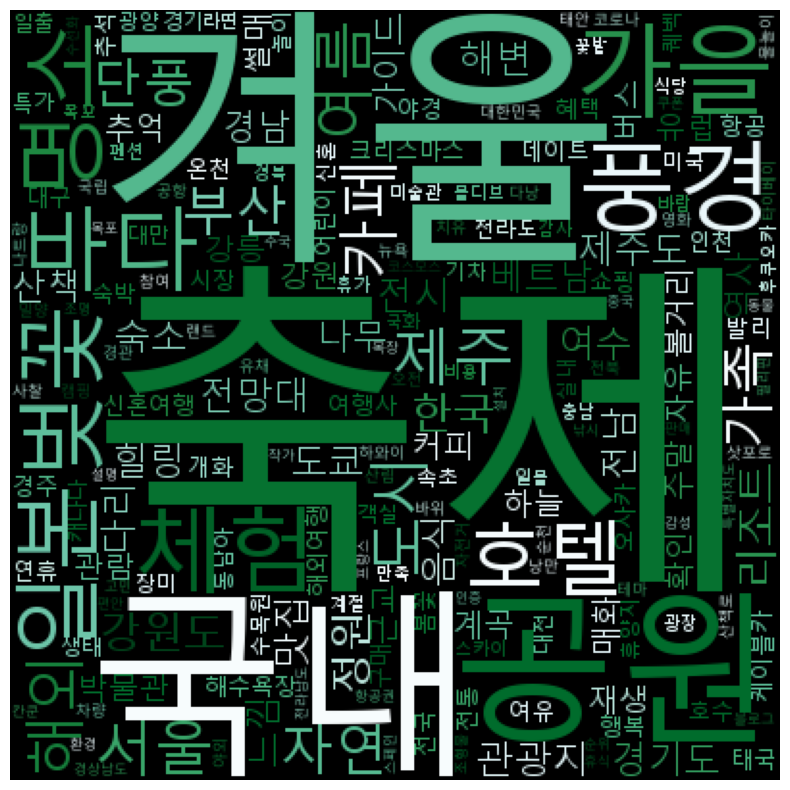

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [26]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'국내': 268,
 '축제': 243,
 '겨울': 180,
 '가을': 158,
 '해외': 144,
 '여행사': 107,
 '여름': 79,
 '일본': 77,
 '명소': 74,
 '벚꽃': 72,
 '대구': 70,
 '강원도': 69,
 '일자': 61,
 '제주도': 59,
 '공원': 58,
 '제주': 54,
 '바다': 53,
 '가족': 53,
 '단풍': 53,
 '서울': 52,
 '경남': 48,
 '신혼': 46,
 '특가': 42,
 '부산': 42,
 '추석': 40,
 '전남': 39,
 '여수': 38,
 '근교': 38,
 '연휴': 37,
 '탈출': 36,
 '경기도': 36,
 '한국': 35,
 '전라도': 35,
 '강릉': 34,
 '관광지': 34,
 '봄꽃': 33,
 '버스': 31,
 '매화': 31,
 '도쿄': 30,
 '정원': 29,
 '개화': 29,
 '전국': 28,
 '해외여행': 28,
 '충남': 27,
 '데이트': 27,
 '도시': 26,
 '당일': 25,
 '새해': 24,
 '테마': 24,
 '전망대': 24,
 '전북': 24,
 '캐나다': 24,
 '초록': 24,
 '양훈': 23,
 '카페': 23,
 '삼성': 22,
 '볼거리': 22,
 '주말': 22,
 '인천': 21,
 '크리스마스': 21,
 '풍경': 21,
 '동남아': 20,
 '광양': 20,
 '순위': 20,
 '숙소': 20,
 '호텔': 20,
 '코로나': 20,
 '대전': 20,
 '전시': 19,
 '속초': 19,
 '경기': 19,
 '대만': 19,
 '나들이': 19,
 '베트남': 19,
 '리조트': 19,
 '힐링': 19,
 '체험': 19,
 '마무리': 18,
 '자연': 18,
 '박람회': 18,
 '고창': 18,
 '순천': 18,
 '발리': 18,
 '태안': 18,
 '경북': 18,
 '중순': 17,
 '절정': 17,
 '역사': 17,
 '계곡

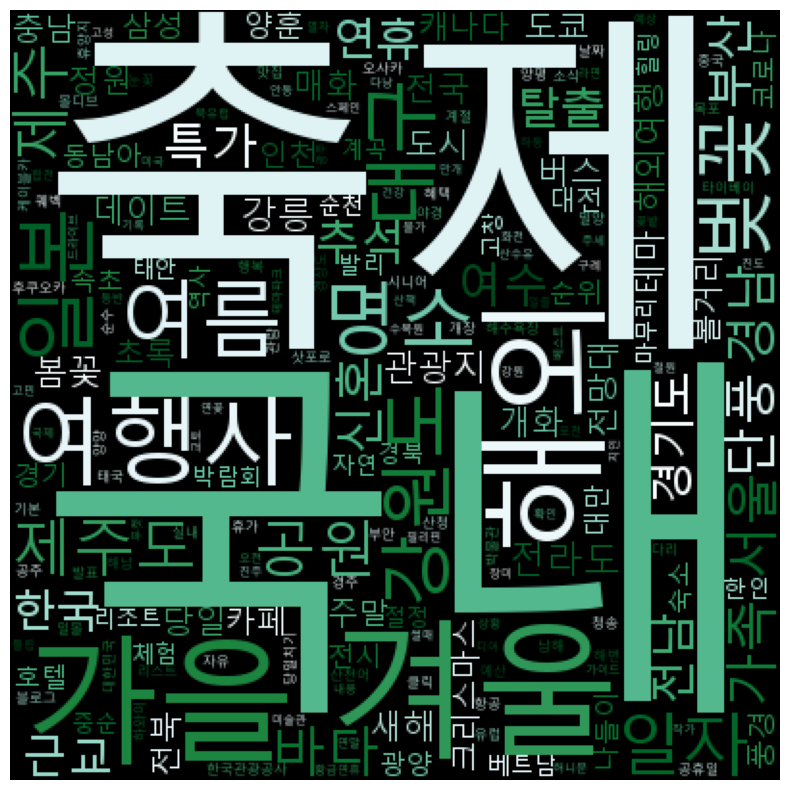

In [27]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [28]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'국내': 203,
 '축제': 124,
 '겨울': 122,
 '가을': 105,
 '해외': 101,
 '명소': 57,
 '강원도': 42,
 '일본': 41,
 '제주': 40,
 '가족': 40,
 '벚꽃': 39,
 '공원': 39,
 '여름': 39,
 '단풍': 38,
 '전남': 34,
 '경남': 33,
 '부산': 32,
 '근교': 32,
 '서울': 30,
 '개화': 28,
 '신혼여행': 28,
 '해외여행': 27,
 '대구': 26,
 '여행사': 26,
 '데이트': 25,
 '전라도': 25,
 '제주도': 23,
 '삼성': 22,
 '퀘벡': 22,
 '도쿄': 21,
 '추석': 20,
 '순위': 20,
 '여수': 19,
 '경기도': 19,
 '매화': 19,
 '전국': 18,
 '몽골': 18,
 '전북': 18,
 '연휴': 18,
 '봄꽃': 18,
 '신혼': 18,
 '베스트': 17,
 '캐나다': 17,
 '볼거리': 17,
 '동남아': 17,
 '관광지': 17,
 '크리스마스': 17,
 '당일치기': 14,
 '충남': 14,
 '광양': 14,
 '카페': 13,
 '밀양': 13,
 '호텔': 13,
 '대전': 13,
 '고창': 13,
 '풍경': 13,
 '뉴욕': 13,
 '태국': 13,
 '경북': 13,
 '실내': 12,
 '박물관': 12,
 '바다': 11,
 '경상도': 11,
 '몰디브': 11,
 '휴양지': 11,
 '경주': 11,
 '리조트': 11,
 '리스트': 11,
 '정원': 11,
 '삿포로': 11,
 '자유': 11,
 '야경': 11,
 '베트남': 11,
 '휴가': 11,
 '강릉': 11,
 '속초': 10,
 '맛집': 10,
 '황금연휴': 10,
 '수목원': 10,
 '숙소': 10,
 '하동': 10,
 '다리': 10,
 '합천': 10,
 '미국': 10,
 '박람회': 10,
 '절정': 10,
 '장미': 9,
 '순천': 

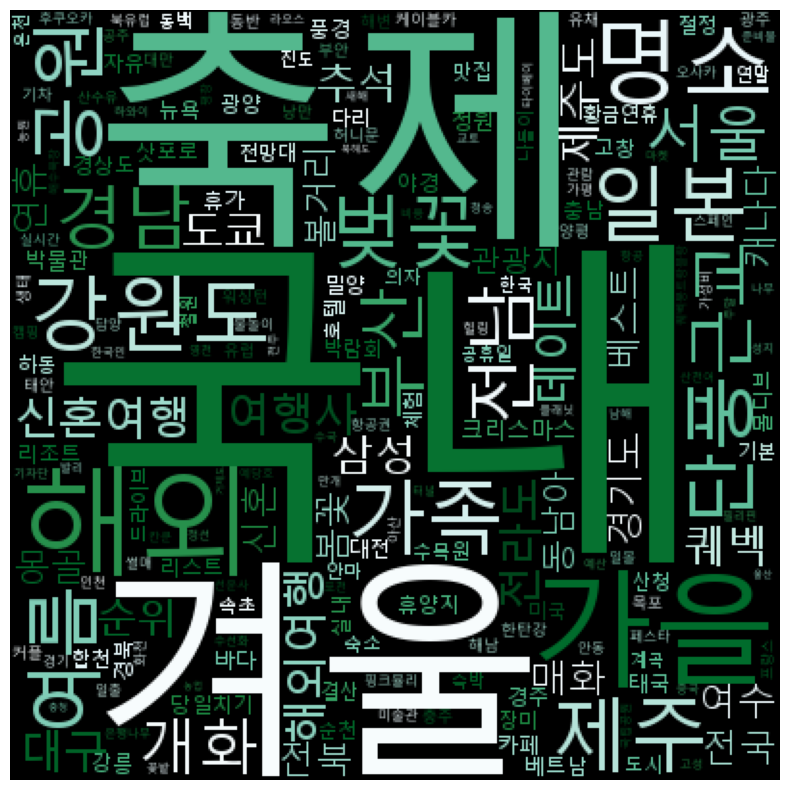

In [29]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Spring WordCloud]

In [30]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = spring_word_counts.set_index('word').to_dict()['count']
dic_word

{'벚꽃': 678,
 '축제': 523,
 '공원': 318,
 '매화': 233,
 '명소': 227,
 '봄꽃': 200,
 '개화': 182,
 '국내': 163,
 '산수유': 145,
 '풍경': 144,
 '수선화': 130,
 '제주': 128,
 '제주도': 119,
 '일본': 113,
 '바다': 112,
 '유채': 104,
 '광양': 104,
 '정원': 104,
 '체험': 99,
 '전남': 86,
 '여수': 81,
 '서울': 79,
 '산책': 78,
 '경남': 78,
 '구례': 73,
 '후쿠오카': 71,
 '힐링': 68,
 '카페': 68,
 '튤립': 68,
 '나무': 67,
 '만개': 65,
 '볼거리': 64,
 '강릉': 63,
 '주말': 63,
 '관광지': 58,
 '다리': 57,
 '가족': 56,
 '대구': 54,
 '경기도': 54,
 '하동': 53,
 '자유': 52,
 '도시': 52,
 '박물관': 49,
 '전망대': 47,
 '가옥': 47,
 '해외': 46,
 '합천': 46,
 '전국': 46,
 '경주': 46,
 '창경궁': 45,
 '혜택': 44,
 '산책로': 44,
 '황매산': 43,
 '강원': 43,
 '광장': 42,
 '재생': 42,
 '발리': 41,
 '버스': 41,
 '베트남': 40,
 '고성': 40,
 '선도': 40,
 '진달래': 39,
 '부산': 39,
 '하늘': 39,
 '역사': 39,
 '도쿄': 39,
 '대전': 38,
 '유성온천': 38,
 '인천': 38,
 '리조트': 37,
 '자전거': 37,
 '호텔': 37,
 '강원도': 37,
 '서산': 37,
 '한국': 37,
 '영천': 37,
 '관람': 36,
 '자연': 36,
 '나들이': 36,
 '오륙도': 36,
 '전시': 36,
 '남도': 36,
 '온천': 35,
 '서귀포시': 35,
 '해수욕장': 35,
 '철쭉': 35,
 '제주시': 35

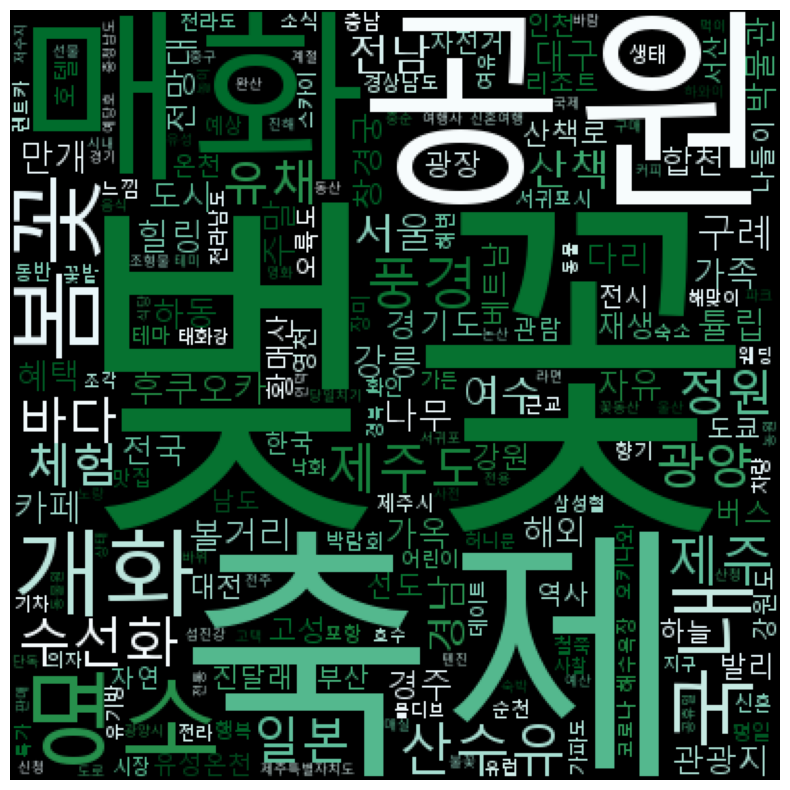

In [31]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Summer WordCloud]

In [32]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = summer_word_counts.set_index('word').to_dict()['count']
dic_word

{'여름': 323,
 '축제': 253,
 '바다': 223,
 '국내': 222,
 '계곡': 163,
 '공원': 138,
 '체험': 132,
 '일본': 131,
 '부산': 126,
 '해변': 117,
 '장미': 115,
 '해수욕장': 109,
 '나트랑': 109,
 '물놀이': 108,
 '도시': 107,
 '해외': 103,
 '풍경': 102,
 '여행사': 99,
 '관광지': 95,
 '자연': 93,
 '가족': 89,
 '카페': 86,
 '제주': 85,
 '특가': 84,
 '맛집': 83,
 '트레킹': 83,
 '강원도': 82,
 '명소': 81,
 '리조트': 80,
 '산림': 79,
 '호텔': 77,
 '연꽃': 73,
 '대구': 70,
 '가이드': 65,
 '강릉': 65,
 '베트남': 64,
 '몽골': 63,
 '음식': 63,
 '한국': 62,
 '경남': 57,
 '치유': 57,
 '국립': 56,
 '제주도': 55,
 '터널': 55,
 '힐링': 54,
 '단양': 50,
 '자유': 50,
 '놀이터': 49,
 '숙소': 49,
 '휴가': 49,
 '시원': 48,
 '역사': 48,
 '전남': 48,
 '곡성': 48,
 '전라도': 47,
 '양양': 47,
 '버스': 47,
 '서울': 46,
 '속초': 46,
 '테마파크': 46,
 '갯벌': 46,
 '세부': 45,
 '태교': 44,
 '경기도': 44,
 '놀이': 42,
 '전망대': 42,
 '여유': 42,
 '숙박': 41,
 '뉴욕': 41,
 '여수': 40,
 '하늘': 40,
 '산책': 39,
 '전주': 39,
 '휴양지': 39,
 '캠핑': 39,
 '데이트': 39,
 '강원': 39,
 '펜션': 38,
 '바위': 38,
 '여름휴가': 37,
 '복지': 37,
 '추억': 36,
 '한강': 36,
 '다리': 36,
 '페스티벌': 36,
 '동남아': 35,
 '무이네': 35,


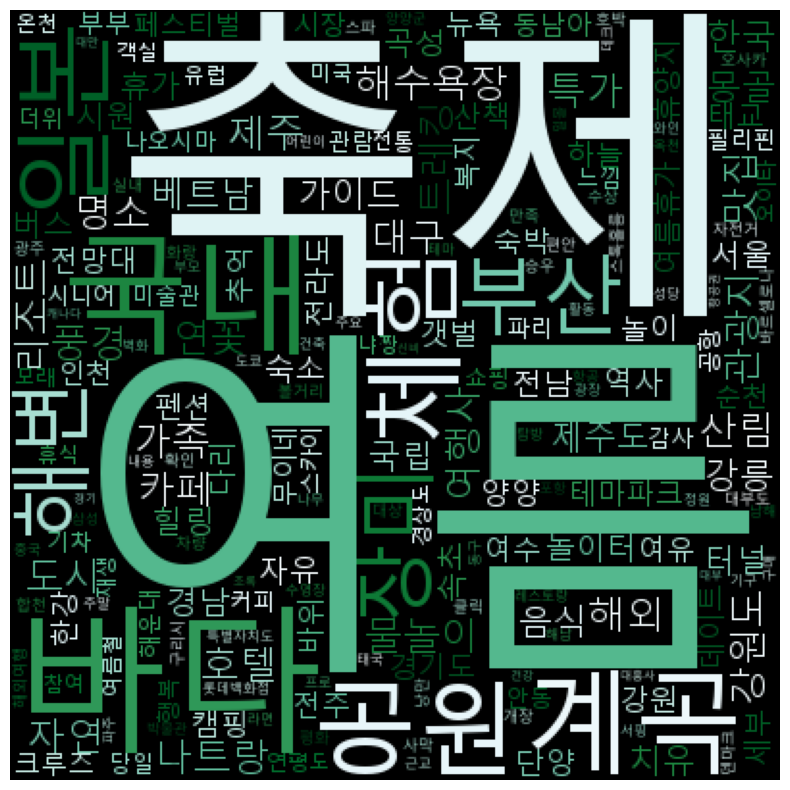

In [33]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Autumn WordCloud]

In [34]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = autumn_word_counts.set_index('word').to_dict()['count']
dic_word

{'가을': 638,
 '축제': 311,
 '단풍': 269,
 '공원': 183,
 '풍경': 163,
 '체험': 142,
 '정원': 141,
 '국내': 138,
 '명소': 137,
 '퀘벡': 127,
 '서울': 126,
 '가이드': 123,
 '경기도': 107,
 '추석': 98,
 '캐나다': 95,
 '호텔': 83,
 '연휴': 76,
 '쇼핑': 73,
 '핑크뮬리': 71,
 '시장': 71,
 '은행나무': 71,
 '가족': 68,
 '자연': 67,
 '경남': 67,
 '산청': 67,
 '힐링': 67,
 '근교': 66,
 '숙박': 66,
 '생태': 65,
 '코스모스': 64,
 '역사': 63,
 '경주': 63,
 '국화': 62,
 '하늘': 62,
 '감사': 59,
 '나무': 59,
 '약초': 58,
 '카페': 58,
 '억새': 57,
 '자전거': 57,
 '일본': 56,
 '전시': 56,
 '포천': 55,
 '한옥': 55,
 '경기': 55,
 '전남': 53,
 '경관': 52,
 '추억': 51,
 '여수': 50,
 '한국': 50,
 '밀양': 49,
 '행복': 49,
 '관광지': 48,
 '전통': 47,
 '산책': 47,
 '제주': 47,
 '음식': 46,
 '수목원': 46,
 '바다': 46,
 '홍성군': 46,
 '관람': 46,
 '절정': 45,
 '스타': 44,
 '강원': 44,
 '호수': 43,
 '전국': 43,
 '펜션': 43,
 '강원도': 42,
 '맛집': 42,
 '렌트카': 42,
 '몬트리올': 41,
 '태안': 40,
 '주말': 39,
 '다리': 39,
 '일몰': 39,
 '설명': 39,
 '충남': 39,
 '핑크': 39,
 '재생': 38,
 '경상남도': 38,
 '와인': 38,
 '전망대': 38,
 '볼거리': 37,
 '만족': 37,
 '아가페': 37,
 '도시': 36,
 '영남루': 35,
 '경북': 

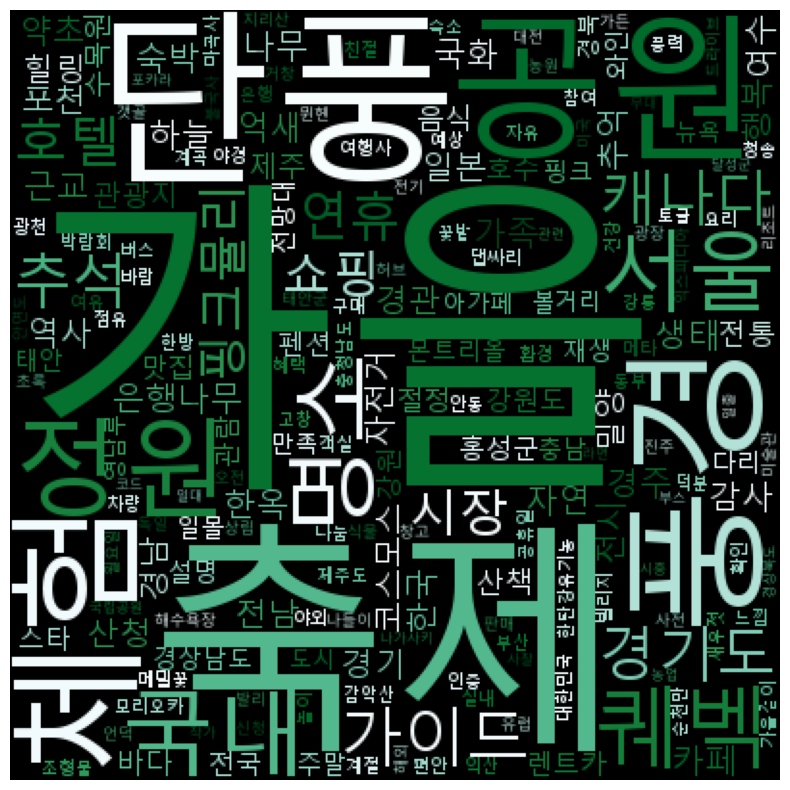

In [35]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Winter WordCloud]

In [36]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = winter_word_counts.set_index('word').to_dict()['count']
dic_word

{'겨울': 976,
 '축제': 497,
 '썰매': 324,
 '국내': 285,
 '체험': 191,
 '풍경': 190,
 '가족': 173,
 '커피': 166,
 '일본': 165,
 '강원도': 156,
 '크리스마스': 153,
 '산천어': 149,
 '부산': 148,
 '서울': 141,
 '명소': 131,
 '바다': 126,
 '도시': 116,
 '여수': 108,
 '경기도': 107,
 '송어': 105,
 '낚시': 105,
 '해외': 103,
 '화천': 100,
 '도쿄': 100,
 '리조트': 94,
 '박물관': 92,
 '제주': 91,
 '전시': 90,
 '카페': 89,
 '해변': 89,
 '목장': 87,
 '어린이': 85,
 '하늘': 83,
 '한국': 80,
 '데이트': 80,
 '다리': 80,
 '전남': 78,
 '가평': 77,
 '자연': 74,
 '실내': 73,
 '느낌': 73,
 '호텔': 72,
 '베트남': 71,
 '공원': 71,
 '평창': 69,
 '놀이': 68,
 '주말': 67,
 '볼거리': 66,
 '대관령': 65,
 '유럽': 65,
 '빙벽': 63,
 '숙소': 62,
 '빌리지': 61,
 '삿포로': 61,
 '해외여행': 60,
 '펜션': 60,
 '해운대': 60,
 '케이블카': 59,
 '일출': 59,
 '전망대': 58,
 '관광지': 58,
 '조명': 56,
 '온천': 56,
 '확인': 55,
 '재생': 55,
 '오사카': 54,
 '쇼핑': 52,
 '프랑스': 52,
 '설치': 50,
 '동백': 49,
 '계곡': 49,
 '마켓': 49,
 '스위스': 49,
 '강릉': 48,
 '항공': 48,
 '혜택': 47,
 '추억': 47,
 '정원': 47,
 '스튜디오': 46,
 '근교': 46,
 '관람': 46,
 '다낭': 45,
 '진도': 44,
 '치유': 44,
 '구이': 44,
 '청송': 43,
 '제

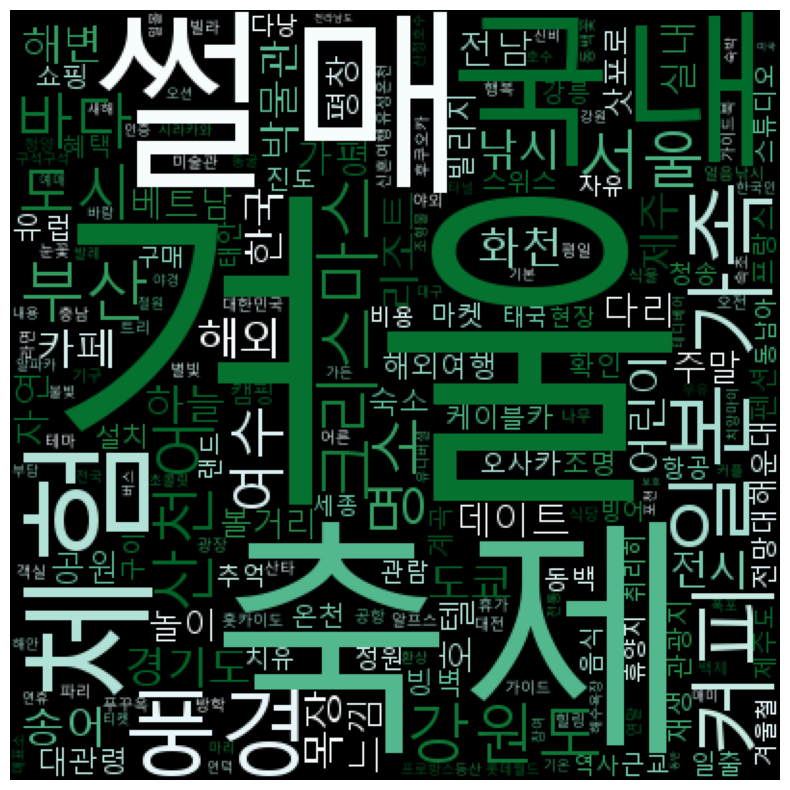

In [37]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기